In [ ]:
!rm -rf sample_data
!git clone https://github.com/Lin-Sinorodin/Military-Vehicles-Tracking

In [ ]:
#@title __Convert Video to Frames__

import cv2

video_dir = "Military-Vehicles-Tracking/test_videos" #@param {type:"string"}
video_name = "tank_mud" #@param {type:"string"}
video_path = f'{video_dir}/{video_name}.mp4'

# create folder for the frames
frames_dir = "Military-Vehicles-Tracking/test_videos" #@param {type:"string"}
frames_path = f'{frames_dir}/{video_name}'

!mkdir "$frames_dir"
!mkdir "$frames_path"

#@markdown Don't save all frames, only save each __ frames:
frames_step =  1#@param {type:"integer"}

# Convert video to frames
count = 0
success = True
vidcap = cv2.VideoCapture(video_path)
while success:
    if (count%frames_step == 0):                                          
        success, img = vidcap.read()

        frame_name = f'{frames_path}/{video_name}_{count+1:05d}.jpg'
        cv2.imwrite(frame_name, img)
        print(f"Saved frame {frame_name}")
    else:
        success,image = vidcap.read()                                 
    count += 1                                                       

In [ ]:
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
%cd LoFTR

# Download pretrained weights
!mkdir weights 
%cd weights/
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ../../

import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from LoFTR.src.utils.plotting import make_matching_figure
from LoFTR.src.loftr import LoFTR, default_cfg

device = 'cpu'


In [4]:
class FeatureMatching:
    def __init__(self):
        """
        LoFTR: Detector-Free Local Feature Matching with Transformers
        Source: https://github.com/zju3dv/LoFTR
        """
        matcher = LoFTR(config=default_cfg)
        matcher.load_state_dict(torch.load("LoFTR/weights/outdoor_ds.ckpt")['state_dict'])
        self.matcher = matcher.eval().to(device)

    @staticmethod
    def _img_to_LoFTR_format(img_raw):
        """Convert opencv BGR image to normalaized grayscale tensor for LoFTR"""
        img_bw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)
        img_bw = cv2.resize(img_bw, (640, 480))
        img = torch.from_numpy(img_bw)[None][None].to(device) / 255.
        return img

    def match(self, img0, img1, min_conf=0.95):
        """Perform feature matching between 2 pictures"""
        img0 = self._img_to_LoFTR_format(img0)
        img1 = self._img_to_LoFTR_format(img1)
        batch = {'image0': img0, 'image1': img1}

        # Inference with LoFTR and get prediction
        with torch.no_grad():
            self.matcher(batch)
            mkpts0 = batch['mkpts0_f'].cpu().numpy()
            mkpts1 = batch['mkpts1_f'].cpu().numpy()
            match_conf = batch['mconf'].cpu().numpy()

        # keep only certain matches
        mkpts0 = mkpts0[match_conf>min_conf]
        mkpts1 = mkpts1[match_conf>min_conf]
        match_conf = match_conf[match_conf>min_conf]

        return mkpts0, mkpts1, match_conf

    @staticmethod
    def view_match(img0, img1, points_curr, points_next, match_conf, dpi=75): 
        color = cm.jet(match_conf, alpha=0.7)

        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        img0 = cv2.resize(img0, (640, 480))
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (640, 480))

        fig = make_matching_figure(img0, img1, points_curr, points_next, color, 
                                   points_curr, points_next, dpi=dpi)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


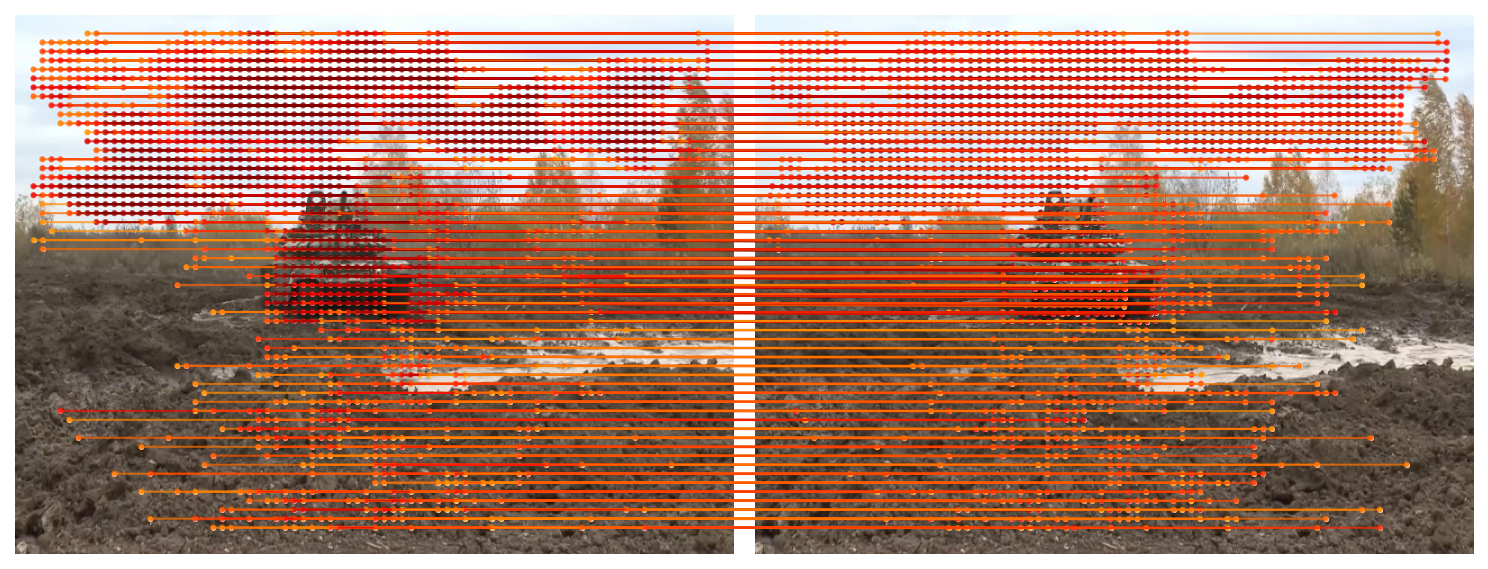

In [5]:
img0 = cv2.imread('/content/Military-Vehicles-Tracking/test_videos/tank_mud/tank_mud_00001.jpg')
img1 = cv2.imread('/content/Military-Vehicles-Tracking/test_videos/tank_mud/tank_mud_00005.jpg')

feature_matcher = FeatureMatching()

points_curr, points_next, match_conf = feature_matcher.match(img0, img1, 0.75)   

feature_matcher.view_match(img0, img1, points_curr, points_next, match_conf, dpi=150)

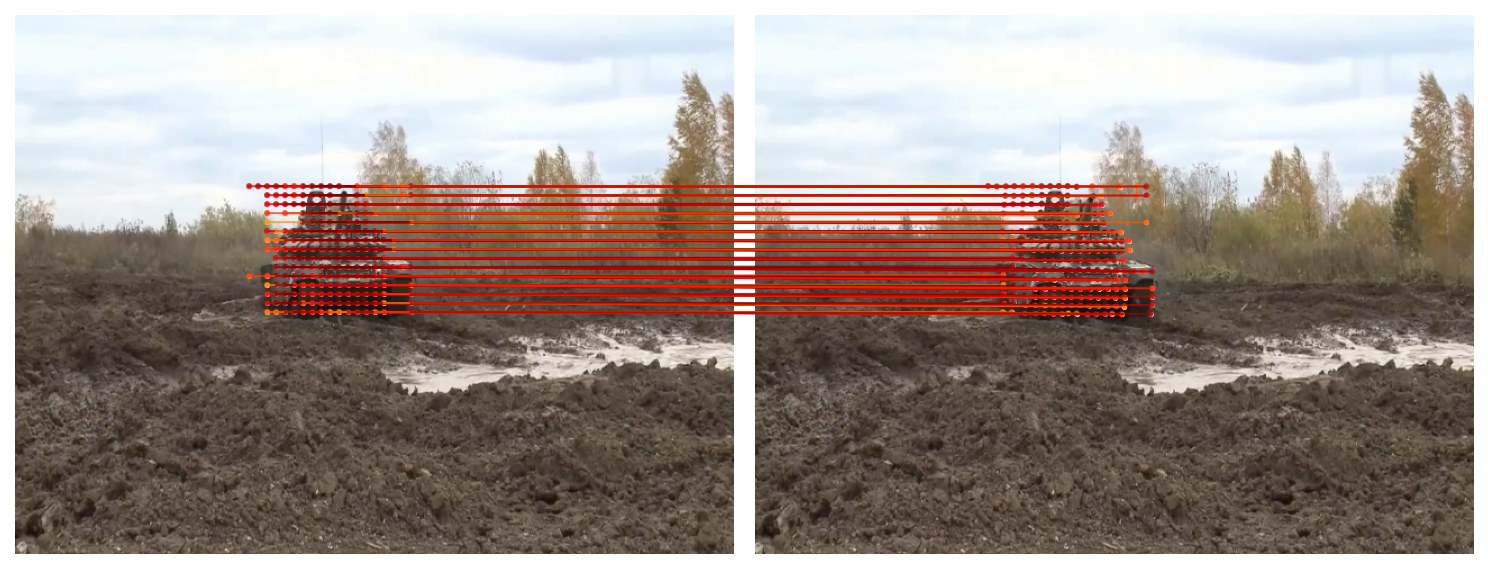

In [8]:
x_bound = [200, 360]
y_bound = [150, 270]

mask = np.logical_and(
    np.logical_and(points_curr[:,0]>x_bound[0], points_curr[:,0]<x_bound[1]),
    np.logical_and(points_curr[:,1]>y_bound[0], points_curr[:,1]<y_bound[1])
)

points_curr1 = points_curr[mask]
points_next1 = points_next[mask]
match_conf1 = match_conf[mask]

feature_matcher.view_match(img0, img1, points_curr1, points_next1, match_conf1, dpi=150)

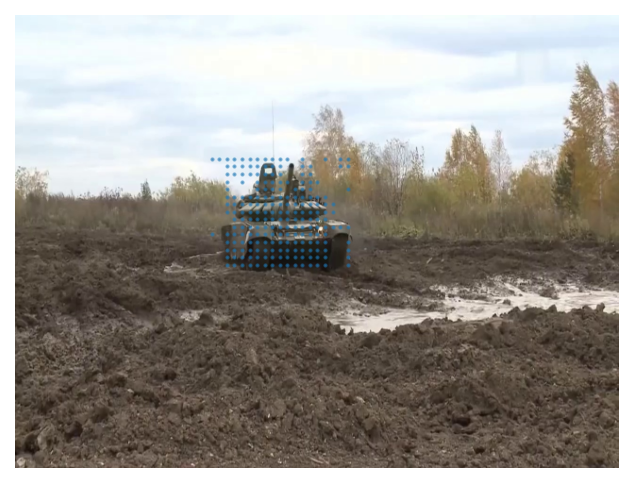

In [7]:
import matplotlib.pyplot as plt

img0_plot = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img0_plot = cv2.resize(img0_plot, (640, 480))

plt.figure(dpi=150)
plt.imshow(img0_plot)
plt.scatter(points_curr1[:, 0], points_curr1[:, 1], s=1, alpha=0.5)
plt.axis('off')
plt.show()